In [973]:
import csv
import re
import math
import matplotlib
import seaborn
import numpy as np
from numpy import nan
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats as ss
from matplotlib import style, colors
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from matplotlib import gridspec
from scipy.spatial.distance import pdist
#pretty display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)
# %config InlineBackend.figure_format = 'retina'


# genes of interest

In [974]:
f0 = '/projects/trans_scratch/validations/workspace/szong/Cervical/epigenetics/genes_of_interest.txt'
# f0 = '/projects/trans_scratch/validations/workspace/szong/Cervical/epigenetics/test_genes.txt'
genes = pd.read_csv(f0, header=None)[0].tolist()
genes[:2]
len(genes)

['AJUBA', 'ARID1A']

98

# process snv and indels

In [975]:
f2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/101_patients/101_selected_columns.txt'
df2 = pd.read_csv(f2, usecols= ['gene', 'patient_ID', 'snpeff_details'], sep='\t')
df2.head(2)

,gene,patient_ID,snpeff_details
0,TACR1,HTMCP-03-06-02026,NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|aAc/aG...
1,TACR1,HTMCP-03-06-02026,NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|aGa/aT...


In [976]:
f3 = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/101_patients/101_indels_strelka_only.txt'
df3 = pd.read_csv(f3, usecols= ['gene', 'patient_ID', 'snpeff_details'], sep='\t')
df3.head(2)

,gene,patient_ID,snpeff_details
0,ZNF434,HTMCP-03-06-02109,SPLICE_SITE_ACCEPTOR(HIGH||||485|ZNF434|protei...
1,IFFO1,HTMCP-03-06-02098,SPLICE_SITE_DONOR(HIGH||||255|IFFO1|protein_co...


In [977]:
df2.shape

(43135, 3)

In [978]:
df3.shape

(412, 3)

In [979]:
df4 = pd.concat([df2, df3])#.set_index(['gene', 'patient_ID'])
df4.head(2)

,gene,patient_ID,snpeff_details
0,TACR1,HTMCP-03-06-02026,NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|aAc/aG...
1,TACR1,HTMCP-03-06-02026,NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|aGa/aT...


In [980]:
df4['impact'] = df4.snpeff_details.apply(lambda x: x.split('(')[0])
df4.head(2)

,gene,patient_ID,snpeff_details,impact
0,TACR1,HTMCP-03-06-02026,NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|aAc/aG...,NON_SYNONYMOUS_CODING
1,TACR1,HTMCP-03-06-02026,NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|aGa/aT...,NON_SYNONYMOUS_CODING


In [981]:
df4 = df4.drop('snpeff_details', axis=1)
df4.head(2)

,gene,patient_ID,impact
0,TACR1,HTMCP-03-06-02026,NON_SYNONYMOUS_CODING
1,TACR1,HTMCP-03-06-02026,NON_SYNONYMOUS_CODING


In [982]:
def impact_type(x):
    xsplit = list(set(x.split(',')))
    type = xsplit[0].upper()
    if len(xsplit) > 1:
        impact = 'Multiple'
    elif len(xsplit) == 1:
         if '+' in xsplit[0]:
             impact = 'Multiple'
         elif type == 'MISSENSE_VARIANT' or type == 'NON_SYNONYMOUS_CODING':
             impact = 'NON_SYNONYMOUS_CODING'
         elif  type == 'SPLICE_SITE_ACCEPTOR' or  type == 'SPLICE_SITE_DONOR':
             impact = 'SPLICE_ACCEPTOR_DONOR'
         elif type == 'STOP_LOST':
             impact = 'STOP_LOST'
         elif type == 'STOP_GAINED':
             impact = 'STOP_GAINED'
         elif  type == 'START_LOST':
             impact = 'START_LOST'
         elif type == 'START_GAINED':
             impact = 'START_GAINED'
         elif type == 'FRAME_SHIFT' or type == 'FRAMESHIFT_VARIANT':
             impact = 'FRAME_SHIFT'
         elif (type == 'INFRAME_DELETION' 
            or type == 'CODON_INSERTION' 
            or type == 'CODON_DELETION' 
            or type == 'CODON_CHANGE_PLUS_CODON_INSERTION' 
            or type == 'CODON_CHANGE_PLUS_CODON_DELETION' 
            or type.lower() == 'disruptive_inframe_deletion'):
              impact = 'CODON_INSERTION_DELETION'                
         else: exit(1);print('ERROR')
    else: print('ERROR', x)
    return impact

In [983]:
df5 = df4.groupby(['gene', 'patient_ID']).agg({'impact': ','.join})
df5['annotation'] = df5['impact'].apply(lambda x: impact_type(x))
df5 = df5.drop('impact', axis=1).unstack()

In [984]:
df5.columns = df5.columns.droplevel(0)
df5.head(2)

patient_ID,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02322,HTMCP-03-06-02326,HTMCP-03-06-02328,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP-03-06-02333
gene,,,,,,,,,,,,,,,,,,,,,
A1BG,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
A1CF,None,None,None,None,NON_SYNONYMOUS_CODING,None,None,None,NON_SYNONYMOUS_CODING,None,...,None,None,None,None,None,None,None,None,None,None


In [985]:
df5.fillna(value=nan, inplace=True)
df5.head()

patient_ID,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02322,HTMCP-03-06-02326,HTMCP-03-06-02328,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP-03-06-02333
gene,,,,,,,,,,,,,,,,,,,,,
A1BG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1CF,NaN,NaN,NaN,NaN,NON_SYNONYMOUS_CODING,NaN,NaN,NaN,NON_SYNONYMOUS_CODING,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2LD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NON_SYNONYMOUS_CODING,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,NaN,NaN,NaN,NaN,NON_SYNONYMOUS_CODING,NaN,NaN,NaN,NaN,NON_SYNONYMOUS_CODING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2ML1,NaN,NaN,NaN,NaN,NON_SYNONYMOUS_CODING,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [986]:
df5['occurrence'] = df5.notnull().sum(axis=1)
df5['percentage'] = ['{0}({1}%)'.format(i[0], int(round(i[1]*100/df5.shape[1]))) for i in zip(df5.index.tolist(), df5.occurrence)]
df5.head(2)

patient_ID,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02322,HTMCP-03-06-02326,HTMCP-03-06-02328,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP-03-06-02333,occurrence,percentage
gene,,,,,,,,,,,,,,,,,,,,,
A1BG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,A1BG(1%)
A1CF,NaN,NaN,NaN,NaN,NON_SYNONYMOUS_CODING,NaN,NaN,NaN,NON_SYNONYMOUS_CODING,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,A1CF(3%)


In [987]:
df5.tail(2)

patient_ID,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02322,HTMCP-03-06-02326,HTMCP-03-06-02328,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP-03-06-02333,occurrence,percentage
gene,,,,,,,,,,,,,,,,,,,,,
hsa-mir-4763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,hsa-mir-4763(3%)
yR211F11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,yR211F11.2(1%)


In [988]:
genes = df5.reindex(index=genes)['occurrence'].sort_values(ascending=False).index.tolist()
genes[:5]

['PIK3CA', 'HLA-B', 'MAGEC1', 'MLL3', 'FAT1']

In [989]:
df5 = df5.reindex(index=genes)#.sort_values(genes, axis=1, ascending=False)
df5.tail(2)

patient_ID,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02322,HTMCP-03-06-02326,HTMCP-03-06-02328,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP-03-06-02333,occurrence,percentage
gene,,,,,,,,,,,,,,,,,,,,,
SMYD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TRIM28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [990]:
dfpct = df5[['percentage']]
dfpct.tail(2)

patient_ID,percentage
gene,
SMYD1,NaN
TRIM28,NaN


In [991]:
dfpct['percentage'] = dfpct['percentage'].fillna(dfpct.index.to_series())
# dfpct['percentage'] = dfpct['percentage'].fillna('{0}{1}'.format(dfpct.index.to_series(), 'xx'))

/home/szong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [992]:
dfpct.tail(3)

patient_ID,percentage
gene,
U2AF1,U2AF1(1%)
SMYD1,SMYD1
TRIM28,TRIM28


In [993]:
ord_genes = dfpct.index.tolist()

In [994]:
df5 = df5.drop(['occurrence', 'percentage'], axis=1)
df5.head(2)

patient_ID,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02322,HTMCP-03-06-02326,HTMCP-03-06-02328,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP-03-06-02333
gene,,,,,,,,,,,,,,,,,,,,,
PIK3CA,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NaN,NaN,Multiple,NaN,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NaN,STOP_GAINED,...,NaN,NaN,NON_SYNONYMOUS_CODING,NaN,NON_SYNONYMOUS_CODING,NaN,NON_SYNONYMOUS_CODING,NaN,NaN,NON_SYNONYMOUS_CODING
HLA-B,NaN,NON_SYNONYMOUS_CODING,NaN,NaN,NON_SYNONYMOUS_CODING,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [995]:
mutations = df5.sort_values(df5.index.tolist(), axis=1, ascending=False)

In [996]:
mutations.head()

patient_ID,HTMCP-03-06-02026,HTMCP-03-06-02074,HTMCP-03-06-02170,HTMCP-03-06-02075,HTMCP-03-06-02070,HTMCP-03-06-02214,HTMCP-03-06-02139,HTMCP-03-06-02002,HTMCP-03-06-02063,HTMCP-03-06-02040,...,HTMCP-03-06-02110,HTMCP-03-06-02057,HTMCP-03-06-02003,HTMCP-03-06-02216,HTMCP-03-06-02225,HTMCP-03-06-02099,HTMCP-03-06-02205,HTMCP-03-06-02217,HTMCP-03-06-02046,HTMCP-03-06-02151
gene,,,,,,,,,,,,,,,,,,,,,
PIK3CA,STOP_GAINED,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HLA-B,NaN,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAGEC1,NaN,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLL3,Multiple,NaN,NaN,NaN,NaN,Multiple,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAT1,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NaN,NaN,NaN,NON_SYNONYMOUS_CODING,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [997]:
ord_patients = mutations.columns.tolist()
ord_patients[:5]

['HTMCP-03-06-02026',
 'HTMCP-03-06-02074',
 'HTMCP-03-06-02170',
 'HTMCP-03-06-02075',
 'HTMCP-03-06-02070']

In [998]:
# mutations = df5.where(df5.isnull(), 1)
# mutations = mutations.fillna(0)
# mutations.head(2)

In [999]:
# mutations = mutations.reindex(expression.index)
# mutations.head(2)

# process expression

In [1000]:
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/epigenetics/NCI_CESC_RPKM_matrix_stranded_from_Reanne_98_genes.txt'
df1 = pd.read_csv(f1, sep='\t')
df1.head(2)

df1['gene'] = df1.transid_genes.apply(lambda x: x.split('_')[1])
df1 = df1.drop('transid_genes', axis=1).set_index('gene')
expression = df1.reindex(genes)
expression.head(2)



expression = np.log10(expression +1)
expression.head(2)
expression.shape

,transid_genes,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,...,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02322,HTMCP-03-06-02326,HTMCP-03-06-02328,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP-03-06-02333
0,ENSG00000129474_AJUBA,16.1833,11.2454,34.9209,20.5245,10.6777,19.7916,22.3689,12.2798,30.9818,...,14.3247,16.5898,7.6998,37.8356,20.4673,5.3086,11.7121,31.2224,13.4566,8.9663
1,ENSG00000117713_ARID1A,30.3235,19.0801,17.7661,13.9126,26.1081,18.4979,26.8617,21.3601,18.2502,...,21.0518,10.7213,18.4021,17.7215,22.8713,21.3822,24.5383,10.8175,38.0075,23.1478


,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02322,HTMCP-03-06-02326,HTMCP-03-06-02328,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP-03-06-02333
gene,,,,,,,,,,,,,,,,,,,,,
PIK3CA,9.4726,10.3312,4.2963,6.5578,2.3017,3.4656,8.1503,4.5022,6.2898,3.4687,...,6.1773,3.7402,2.6661,3.2063,5.1448,2.7117,3.8655,2.5212,5.4175,4.2061
HLA-B,993.3778,1309.5194,564.7026,342.9829,829.8583,938.8075,416.4938,242.1411,774.9398,562.2346,...,273.5054,645.7594,498.6576,981.5481,717.5799,1054.0737,1111.5620,1263.4477,819.9467,1092.2431


,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02266,HTMCP-03-06-02267,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02322,HTMCP-03-06-02326,HTMCP-03-06-02328,HTMCP-03-06-02330,HTMCP-03-06-02332,HTMCP-03-06-02333
gene,,,,,,,,,,,,,,,,,,,,,
PIK3CA,1.020055,1.054276,0.723973,0.878395,0.518738,0.649880,0.961435,0.740536,0.862716,0.650181,...,0.855961,0.675797,0.564204,0.623900,0.788508,0.569573,0.687127,0.546691,0.807366,0.716513
HLA-B,2.997551,3.117443,2.752588,2.536537,2.919527,2.973039,2.620650,2.385858,2.889828,2.750689,...,2.438551,2.810743,2.698672,2.992354,2.856475,3.023283,3.046324,3.101901,2.914315,3.038717


(98, 101)

In [1001]:
expression = expression.reindex(index=ord_genes, columns=ord_patients)

# process CNVs

In [1002]:
f10 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/101_patients/98_gene_cnv_results.txt'
df10 = pd.read_csv(f10, sep='\t')
df10.head(2)

,patient,Ensembl_ID,Gene_Name,Chr,Chr_Start,Chr_End,HMM_State
0,HTMCP-03-06-02109,ENSG00000049618,ARID1B,6,157099063,157530401,0
1,HTMCP-03-06-02098,ENSG00000166164,BRD7,16,50347398,50402845,0


In [1003]:
cnvs = df10.set_index(['Gene_Name', 'patient'])['HMM_State'].unstack()

In [1004]:
# order genes and patients
cnvs = cnvs.reindex(index=ord_genes, columns=ord_patients).fillna(2)

cnvs.head()

patient,HTMCP-03-06-02026,HTMCP-03-06-02074,HTMCP-03-06-02170,HTMCP-03-06-02075,HTMCP-03-06-02070,HTMCP-03-06-02214,HTMCP-03-06-02139,HTMCP-03-06-02002,HTMCP-03-06-02063,HTMCP-03-06-02040,...,HTMCP-03-06-02110,HTMCP-03-06-02057,HTMCP-03-06-02003,HTMCP-03-06-02216,HTMCP-03-06-02225,HTMCP-03-06-02099,HTMCP-03-06-02205,HTMCP-03-06-02217,HTMCP-03-06-02046,HTMCP-03-06-02151
Gene_Name,,,,,,,,,,,,,,,,,,,,,
PIK3CA,2.0,3.0,3.0,4.0,3.0,3.0,4.0,5.0,4.0,3.0,...,5.0,4.0,3.0,2.0,3.0,4.0,2.0,3.0,3.0,5.0
HLA-B,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,...,3.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0
MAGEC1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
MLL3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
FAT1,2.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,...,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0


In [1005]:
# get coordinates where there are copy number changes
cnvtmp = cnvs.reset_index(drop=True)
cnvtmp.head(2)

cnvtmp.columns = [i for i in range(cnvtmp.shape[1])]
cnvtmp.head(2)

patient,HTMCP-03-06-02026,HTMCP-03-06-02074,HTMCP-03-06-02170,HTMCP-03-06-02075,HTMCP-03-06-02070,HTMCP-03-06-02214,HTMCP-03-06-02139,HTMCP-03-06-02002,HTMCP-03-06-02063,HTMCP-03-06-02040,...,HTMCP-03-06-02110,HTMCP-03-06-02057,HTMCP-03-06-02003,HTMCP-03-06-02216,HTMCP-03-06-02225,HTMCP-03-06-02099,HTMCP-03-06-02205,HTMCP-03-06-02217,HTMCP-03-06-02046,HTMCP-03-06-02151
0,2.0,3.0,3.0,4.0,3.0,3.0,4.0,5.0,4.0,3.0,...,5.0,4.0,3.0,2.0,3.0,4.0,2.0,3.0,3.0,5.0
1,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,...,3.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,2.0,3.0,3.0,4.0,3.0,3.0,4.0,5.0,4.0,3.0,...,5.0,4.0,3.0,2.0,3.0,4.0,2.0,3.0,3.0,5.0
1,2.0,1.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,...,3.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0


In [1006]:
p_loss = []
q_loss = []
cn_loss = []
for row in cnvtmp.index: 
    for col in cnvtmp.columns:
        if cnvtmp.get_value(row,col) <2:
            cn_loss.append(cnvtmp.loc[row,col])
            p_loss.append(col+.25)
            q_loss.append(row-.25)
#             print([row, col])
# print(x,y)
#                

p_gain =[]
q_gain = []
cn_gain = []
for row in cnvtmp.index: 
    for col in cnvtmp.columns:
        if cnvtmp.get_value(row,col) >2:
            cn_gain.append(cnvtmp.loc[row,col])
            p_gain.append(col+.25)
            q_gain.append(row-.25)

In [1007]:
cns = np.sort(pd.Series(cnvtmp.values.ravel()).unique()).tolist()
cns.remove(2)
cns

[0.0, 1.0, 3.0, 4.0, 5.0]

In [1008]:
cnclrs = ["black", "blue", "green","brown","#F0E442", 'gray']
# values = np.arange(0.15, round(len(impact_types)/10, 2), .1)
# values
cnvmap = dict(zip(cns, cnclrs[:len(cns)]))
cnvmap

{0.0: 'black', 1.0: 'blue', 3.0: 'green', 4.0: 'brown', 5.0: '#F0E442'}

In [1009]:
cnvclr_loss = [cnvmap[i] for i in cn_loss]
cnvclr_gain = [cnvmap[i] for i in cn_gain]

# make oncoprint

In [1010]:
expression.head(2)

,HTMCP-03-06-02026,HTMCP-03-06-02074,HTMCP-03-06-02170,HTMCP-03-06-02075,HTMCP-03-06-02070,HTMCP-03-06-02214,HTMCP-03-06-02139,HTMCP-03-06-02002,HTMCP-03-06-02063,HTMCP-03-06-02040,...,HTMCP-03-06-02110,HTMCP-03-06-02057,HTMCP-03-06-02003,HTMCP-03-06-02216,HTMCP-03-06-02225,HTMCP-03-06-02099,HTMCP-03-06-02205,HTMCP-03-06-02217,HTMCP-03-06-02046,HTMCP-03-06-02151
gene,,,,,,,,,,,,,,,,,,,,,
PIK3CA,0.650181,0.708540,0.780886,0.802774,0.751918,0.741994,0.838874,1.054276,0.892901,0.685822,...,0.938760,0.796893,0.723973,0.552559,0.606768,0.726711,0.467312,0.732072,0.845017,0.700054
HLA-B,2.750689,2.120828,2.508502,2.120478,2.814644,2.998636,2.909421,3.117443,3.091861,2.542409,...,2.234668,2.153046,2.752588,1.833299,2.372828,2.677719,2.449937,2.774395,2.906943,2.532538


In [1011]:
expression = pd.merge(expression, dfpct, left_index=True, right_index=True).set_index('percentage', drop=True)
expression.head(2)

,HTMCP-03-06-02026,HTMCP-03-06-02074,HTMCP-03-06-02170,HTMCP-03-06-02075,HTMCP-03-06-02070,HTMCP-03-06-02214,HTMCP-03-06-02139,HTMCP-03-06-02002,HTMCP-03-06-02063,HTMCP-03-06-02040,...,HTMCP-03-06-02110,HTMCP-03-06-02057,HTMCP-03-06-02003,HTMCP-03-06-02216,HTMCP-03-06-02225,HTMCP-03-06-02099,HTMCP-03-06-02205,HTMCP-03-06-02217,HTMCP-03-06-02046,HTMCP-03-06-02151
percentage,,,,,,,,,,,,,,,,,,,,,
PIK3CA(34%),0.650181,0.708540,0.780886,0.802774,0.751918,0.741994,0.838874,1.054276,0.892901,0.685822,...,0.938760,0.796893,0.723973,0.552559,0.606768,0.726711,0.467312,0.732072,0.845017,0.700054
HLA-B(25%),2.750689,2.120828,2.508502,2.120478,2.814644,2.998636,2.909421,3.117443,3.091861,2.542409,...,2.234668,2.153046,2.752588,1.833299,2.372828,2.677719,2.449937,2.774395,2.906943,2.532538


In [1012]:
mutations.head(2)

patient_ID,HTMCP-03-06-02026,HTMCP-03-06-02074,HTMCP-03-06-02170,HTMCP-03-06-02075,HTMCP-03-06-02070,HTMCP-03-06-02214,HTMCP-03-06-02139,HTMCP-03-06-02002,HTMCP-03-06-02063,HTMCP-03-06-02040,...,HTMCP-03-06-02110,HTMCP-03-06-02057,HTMCP-03-06-02003,HTMCP-03-06-02216,HTMCP-03-06-02225,HTMCP-03-06-02099,HTMCP-03-06-02205,HTMCP-03-06-02217,HTMCP-03-06-02046,HTMCP-03-06-02151
gene,,,,,,,,,,,,,,,,,,,,,
PIK3CA,STOP_GAINED,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HLA-B,NaN,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1013]:
# mutations.isnull()

In [1014]:
mutations = pd.merge(mutations, dfpct, left_index=True, right_index=True).set_index('percentage', drop=True)
# mutations = mutations.fillna(None)
mutations.head(2)

patient_ID,HTMCP-03-06-02026,HTMCP-03-06-02074,HTMCP-03-06-02170,HTMCP-03-06-02075,HTMCP-03-06-02070,HTMCP-03-06-02214,HTMCP-03-06-02139,HTMCP-03-06-02002,HTMCP-03-06-02063,HTMCP-03-06-02040,...,HTMCP-03-06-02110,HTMCP-03-06-02057,HTMCP-03-06-02003,HTMCP-03-06-02216,HTMCP-03-06-02225,HTMCP-03-06-02099,HTMCP-03-06-02205,HTMCP-03-06-02217,HTMCP-03-06-02046,HTMCP-03-06-02151
percentage,,,,,,,,,,,,,,,,,,,,,
PIK3CA(34%),STOP_GAINED,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HLA-B(25%),NaN,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1015]:
muttmp = mutations.copy()
muttmp.columns = [i for i in range(muttmp.shape[1])]
muttmp.head(2)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
percentage,,,,,,,,,,,,,,,,,,,,,
PIK3CA(34%),STOP_GAINED,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HLA-B(25%),NaN,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1016]:
# can not sort value here because expression and cnv depended on mutations index
# muttmp = muttmp.sort_values(muttmp.index.tolist(), axis=1, ascending=False)

In [1017]:
muttmp = muttmp.reset_index(drop=True)

In [1018]:
muttmp.head(2)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,STOP_GAINED,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1019]:
# find out unique values in a dataframe
impact_types = pd.Series(muttmp.values.ravel()).unique().tolist()# or # df1.stack().unique()
# impact_types.remove(None)
impact_types.remove(nan)
impact_types

['STOP_GAINED',
 'NON_SYNONYMOUS_CODING',
 'Multiple',
 'SPLICE_ACCEPTOR_DONOR',
 'CODON_INSERTION_DELETION',
 'FRAME_SHIFT']

In [1020]:
num_types = len(impact_types)
clrs = ["purple","blue", "black", "yellow","green","brown","#F0E442"]
# values = np.arange(0.15, round(len(impact_types)/10, 2), .1)
# values
map_dict = dict(zip(impact_types, clrs[:len(impact_types)]))
map_dict

{'CODON_INSERTION_DELETION': 'green',
 'FRAME_SHIFT': 'brown',
 'Multiple': 'black',
 'NON_SYNONYMOUS_CODING': 'blue',
 'SPLICE_ACCEPTOR_DONOR': 'yellow',
 'STOP_GAINED': 'purple'}

In [1021]:
# muttmp = muttmp.apply(lambda x: x.map(map_dict))
# pd.Series(muttmp.values.ravel()).unique()
# muttmp.shape

In [1022]:
# mutations = muttmp.copy()
# lgds = sorted(map_dict, key=map_dict.get, reverse=False)
# # lgds.remove(0)
# mutations.head(2)

In [1023]:
muttmp.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,STOP_GAINED,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Multiple,NaN,NaN,NaN,NaN,Multiple,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING,NaN,NaN,NaN,NON_SYNONYMOUS_CODING,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1024]:
# figure out mutation coordinates

x =[]
y = []
v = []

for row in muttmp.index: 
    for col in muttmp.columns:
        vl =  muttmp.get_value(row,col)        
        if not pd.isnull(vl): # keep non na values
            v.append(vl)
            x.append(col-0.25)
            y.append(row-0.25)


assert len(v) == len(x) == len(y)
print(len(v))

580


In [1025]:
expression.shape[1]*.2
expression.shape[0]*.2

20.200000000000003

19.6

In [1026]:

pntclrs = [map_dict[i] for i in v  if str(i) != 'nan']
# pntclrs

In [1027]:
assert (expression.columns == cnvs.columns).all() == True

In [1028]:
expression.index

Index(['PIK3CA(34%)', 'HLA-B(25%)', 'MAGEC1(22%)', 'MLL3(18%)', 'FAT1(17%)',
       'LRP1B(16%)', 'HLA-A(15%)', 'MLL2(15%)', 'FBXW7(14%)', 'ATR(13%)',
       'TPR(12%)', 'HLA-C(11%)', 'FAT2(10%)', 'CREBBP(10%)', 'ATRX(9%)',
       'EP300(9%)', 'CASP8(9%)', 'AJUBA(7%)', 'TAF1L(7%)', 'ASXL1(7%)',
       'SF3B1(6%)', 'EZH2(6%)', 'CHD4(6%)', 'CHD3(6%)', 'MAPK1(6%)',
       'NFE2L2(6%)', 'ARID1A(6%)', 'KDM5B(6%)', 'ARID1B(5%)', 'MLL(5%)',
       'EED(5%)', 'ERBB2(5%)', 'BRD4(5%)', 'CHD2(5%)', 'ERBB3(5%)',
       'BAZ1A(5%)', 'KAT2B(5%)', 'RB1(5%)', 'TRRAP(5%)', 'TP53(5%)',
       'SETD2(5%)', 'SIRT7(5%)', 'TAF1(5%)', 'PTEN(5%)', 'PHIP(5%)',
       'SMARCA4(4%)', 'EYA3(4%)', 'SETD1A(4%)', 'DOT1L(4%)', 'MLL4(4%)',
       'CHD6(4%)', 'EZH1(4%)', 'STK11(4%)', 'CHD1(4%)', 'BRWD1(4%)',
       'BRD7(4%)', 'BAZ1B(4%)', 'TGFBR2(4%)', 'SMARCAD1(4%)', 'EP400(4%)',
       'KAT6B(4%)', 'KRAS(4%)', 'ZMYND8(4%)', 'KDM5A(4%)', 'KDM6A(4%)',
       'HDAC9(4%)', 'HDAC6(4%)', 'PBRM1(4%)', 'RSF1(4%)', 'KAT6A(4%

In [1029]:
cnvs.index

Index(['PIK3CA', 'HLA-B', 'MAGEC1', 'MLL3', 'FAT1', 'LRP1B', 'HLA-A', 'MLL2',
       'FBXW7', 'ATR', 'TPR', 'HLA-C', 'FAT2', 'CREBBP', 'ATRX', 'EP300',
       'CASP8', 'AJUBA', 'TAF1L', 'ASXL1', 'SF3B1', 'EZH2', 'CHD4', 'CHD3',
       'MAPK1', 'NFE2L2', 'ARID1A', 'KDM5B', 'ARID1B', 'MLL', 'EED', 'ERBB2',
       'BRD4', 'CHD2', 'ERBB3', 'BAZ1A', 'KAT2B', 'RB1', 'TRRAP', 'TP53',
       'SETD2', 'SIRT7', 'TAF1', 'PTEN', 'PHIP', 'SMARCA4', 'EYA3', 'SETD1A',
       'DOT1L', 'MLL4', 'CHD6', 'EZH1', 'STK11', 'CHD1', 'BRWD1', 'BRD7',
       'BAZ1B', 'TGFBR2', 'SMARCAD1', 'EP400', 'KAT6B', 'KRAS', 'ZMYND8',
       'KDM5A', 'KDM6A', 'HDAC9', 'HDAC6', 'PBRM1', 'RSF1', 'KAT6A', 'PCGF2',
       'TET2', 'KDM2B', 'ARID2', 'BRD3', 'TAF9', 'PHF20', 'CARM1', 'RUVBL1',
       'ELF3', 'SMYD2', 'JAK2', 'PHF8', 'DNMT1', 'DNMT3A', 'HDAC4', 'MTF2',
       'CBFB', 'SHKBP1', 'TET1', 'B2M', 'ZRSR2', 'SETBP1', 'HIST1H3B', 'H3F3A',
       'U2AF1', 'SMYD1', 'TRIM28'],
      dtype='object', name='Gene_Name')

In [1030]:
mutations.index

Index(['PIK3CA(34%)', 'HLA-B(25%)', 'MAGEC1(22%)', 'MLL3(18%)', 'FAT1(17%)',
       'LRP1B(16%)', 'HLA-A(15%)', 'MLL2(15%)', 'FBXW7(14%)', 'ATR(13%)',
       'TPR(12%)', 'HLA-C(11%)', 'FAT2(10%)', 'CREBBP(10%)', 'ATRX(9%)',
       'EP300(9%)', 'CASP8(9%)', 'AJUBA(7%)', 'TAF1L(7%)', 'ASXL1(7%)',
       'SF3B1(6%)', 'EZH2(6%)', 'CHD4(6%)', 'CHD3(6%)', 'MAPK1(6%)',
       'NFE2L2(6%)', 'ARID1A(6%)', 'KDM5B(6%)', 'ARID1B(5%)', 'MLL(5%)',
       'EED(5%)', 'ERBB2(5%)', 'BRD4(5%)', 'CHD2(5%)', 'ERBB3(5%)',
       'BAZ1A(5%)', 'KAT2B(5%)', 'RB1(5%)', 'TRRAP(5%)', 'TP53(5%)',
       'SETD2(5%)', 'SIRT7(5%)', 'TAF1(5%)', 'PTEN(5%)', 'PHIP(5%)',
       'SMARCA4(4%)', 'EYA3(4%)', 'SETD1A(4%)', 'DOT1L(4%)', 'MLL4(4%)',
       'CHD6(4%)', 'EZH1(4%)', 'STK11(4%)', 'CHD1(4%)', 'BRWD1(4%)',
       'BRD7(4%)', 'BAZ1B(4%)', 'TGFBR2(4%)', 'SMARCAD1(4%)', 'EP400(4%)',
       'KAT6B(4%)', 'KRAS(4%)', 'ZMYND8(4%)', 'KDM5A(4%)', 'KDM6A(4%)',
       'HDAC9(4%)', 'HDAC6(4%)', 'PBRM1(4%)', 'RSF1(4%)', 'KAT6A(4%

In [1031]:
assert (cnvs.columns == expression.columns).all() == True
assert (cnvs.columns == mutations.columns).all() == True

In [971]:
# (expression.columns == cnvs.columns == mutations.columns).all()`

[]

[]

[]

[]

/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 50.7 s, sys: 12.5 s, total: 1min 3s
Wall time: 1min 6s


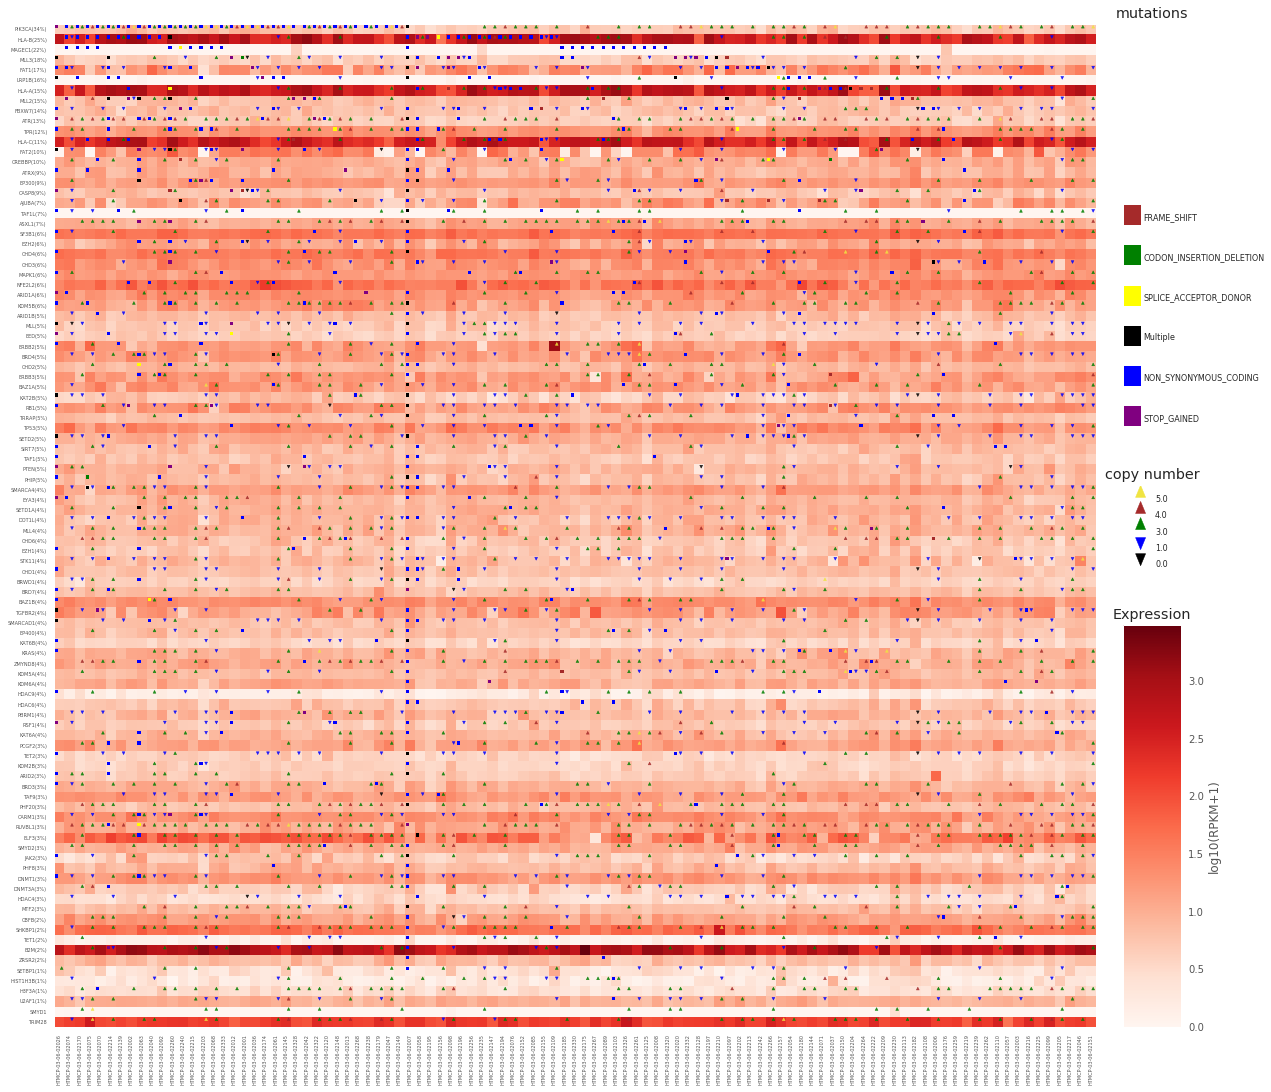

In [1032]:

fig = plt.figure(figsize=(expression.shape[1]*.2, expression.shape[0]*.2))
gs = gridspec.GridSpec(2, 2, 
                       height_ratios=[1,16], 
                       width_ratios=[18,1], 
                       wspace=0.05, # horizontal space
                       hspace=0.0  # vertical space
                      )

# ax1 = fig.add_subplot(gs[0])
# df_pivot=histo.copy()
# # clrs = ['white', "purple", "#E69F00","#009E73","#56B4E9","#377EB8","#E41A1C","#F0E442"]
# clrs = ["purple","#D55E00", "#009E73", "#56B4E9","#377EB8","#E41A1C","#F0E442"]
# bounds = np.arange(0, 0.5, 0.1).tolist()

# # make a color map of fixed colors
# cmap = colors.ListedColormap(clrs)
# norm = colors.BoundaryNorm(bounds, cmap.N)
# img = ax1.imshow(df_pivot.values, interpolation='none', origin='upper', aspect='auto',
#                     cmap=cmap, norm=norm)
# ax1.grid(False)
# _ = plt.yticks(np.arange(0, len(df_pivot.index), 1), df_pivot.index, fontsize=5)
# _ = plt.xticks(np.arange(0, len(df_pivot.columns), 1), df_pivot.columns, fontsize=5, rotation=90)
# # ax1.set


# ax2 = fig.add_subplot(gs[1])
# cbar = plt.colorbar(img, cax=ax2, cmap=cmap, norm=norm, boundaries=bounds, orientation='vertical')

# cbar.ax.get_yaxis().set_ticks([])
# for j, lab in enumerate(lgds):
#     _ = cbar.ax.text(1.0, (4 * j + 1) / 16.0, lab, ha='left', va='center', fontsize=5)
# cbar.ax.get_yaxis().labelpad = 1
# # cbar.ax.set_ylabel('', rotation=270)

ax3 = fig.add_subplot(gs[2])
# img = ax3.imshow(df_pivot.values, interpolation='none', origin='upper',
#                     cmap=cmap, norm=norm)
im = ax3.imshow(expression.values, interpolation='none',origin='upper', cmap='Reds', aspect='auto')#  cmap='Paired')#

# Now adding the colorbar
# plt.colorbar(im, orientation= 'vertical', shrink=0.6, pad=0.02, label='Expression')#'horizontal')

_= plt.yticks(np.arange(0, len(expression.index), 1), expression.index, fontsize=5)
_ = plt.xticks(np.arange(0, len(expression.columns), 1), expression.columns, fontsize=5, rotation=90)
# alpha set marker transparent, linewidths set marker thickness
pnts = plt.scatter(x, y, marker='s',s=10, c=pntclrs, linewidths=0, label='Mutation',alpha=1)
# # plt.scatter(x=[1, 4], y=[1, 1],marker='x',s=20, c='b', linewidths=20, label='SNVs',alpha=1)#, linewidth=10,facecolors='none', edgecolors='b')
# # plt.scatter(x=[1, 4], y=[0, 1], c='k',marker='^',s=10, label='Copy gain',alpha=.85)

gain = plt.scatter(p_gain, q_gain, c=cnvclr_gain,marker='^',s=8, label='Copy gain',alpha=.85)
_ = plt.scatter(p_loss, q_loss, c=cnvclr_loss,marker='v',s=8, label='Copy loss', alpha=.85)
plt.grid(False)
# plt.legend(loc='upper right', bbox_to_anchor=(1.18, 0.95))
# # plt.title('Mutations CNVs and Expression of Chromatin Remodeling Genes')

gs01 = gridspec.GridSpecFromSubplotSpec(3, 1,  height_ratios=[5, 1, 5], subplot_spec=gs[3])
ax4_1 = fig.add_subplot(gs01[0], facecolor='white')
ax4_1.set_title("mutations")
ax4_2 = fig.add_subplot(gs01[1], facecolor='white')
ax4_2.set_title("copy number")
ax4_3 = fig.add_subplot(gs01[2])
ax4_3.set_title("Expression")

_ = plt.colorbar(im,cax=ax4_3, orientation= 'vertical', label='log10(RPKM+1)') 

# plot mutation legend
k = 0
for key in map_dict:
    clr = map_dict[key]
    rect = patches.Rectangle((0,k/10), 0.3, 0.05, linewidth=0.01,edgecolor=clr,facecolor=clr)
    _ = ax4_1.text(0.35, k/10+.02, key, ha='left', va='center', fontsize=8)
    _ = ax4_1.add_patch(rect)
    k+=1
ax4_1.get_xaxis().set_ticks([])
ax4_1.get_yaxis().set_ticks([])

# plot cnv legend
k = 0
for key in cnvmap:
    clr = cnvmap[key]
    if key >2:
        triangle = patches.RegularPolygon((0.3, k/len(cnvmap)+0.1),     # (x,y)
                                          3,              # number of vertices
                                          0.1,            # radius
                                          edgecolor=clr,facecolor=clr)
    if key <2:
        triangle = patches.RegularPolygon((0.3, k/len(cnvmap)+0.1),     # (x,y)
                                          3,              # number of vertices
                                          0.1,            # radius
                                          orientation=math.pi,
                                          edgecolor=clr,facecolor=clr)        
    _ = ax4_2.text(0.55, k/len(cnvmap)+.02, key, ha='left', va='center', fontsize=8)
    _ = ax4_2.add_patch(triangle)
    k+=1
ax4_2.get_xaxis().set_ticks([])
ax4_2.get_yaxis().set_ticks([])


of = '/projects/trans_scratch/validations/workspace/szong/Cervical/epigenetics/test_oncoprint_mutation_cnv_expression_new.png'
%time plt.savefig(of, bbox_inches='tight',dpi=500)